<a href="https://colab.research.google.com/github/chandrashekher123/GITAM-CRT/blob/master/practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 3.8 MB/s eta 0:00:00


In [36]:
import snntorch as snn
import torch
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [4]:
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [5]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 82595226.24it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114063741.83it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26771848.85it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 751648.40it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [6]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [8]:
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
The output is spiking 40.00% of the time.


In [9]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 52.00% of the time.


In [10]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [12]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


In [11]:
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [13]:
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [14]:
for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.view(-1, 784)
    
spk_in = spikegen.rate_conv(images).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([112, 1, 784])


In [15]:
num_steps = 100
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

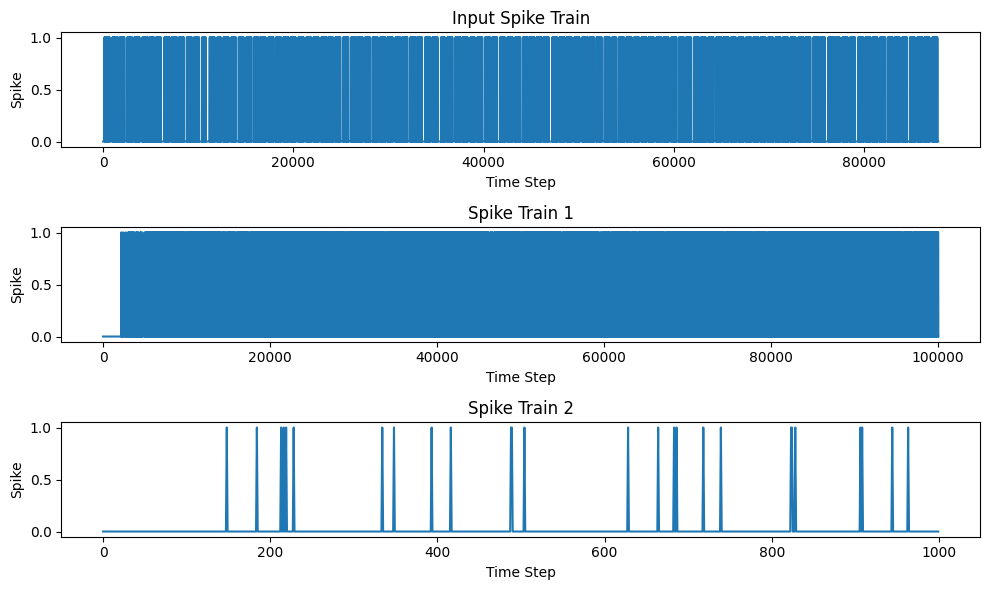

In [16]:

spk_in_reshaped = spk_in.view(-1).detach().numpy()  # Reshape and detach
spk1_rec_reshaped = spk1_rec.view(-1).detach().numpy()
spk2_rec_reshaped = spk2_rec.view(-1).detach().numpy()

# Plot spike trains
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(spk_in_reshaped)
plt.title("Input Spike Train")
plt.xlabel("Time Step")
plt.ylabel("Spike")

plt.subplot(312)
plt.plot(spk1_rec_reshaped)
plt.title("Spike Train 1")
plt.xlabel("Time Step")
plt.ylabel("Spike")

plt.subplot(313)
plt.plot(spk2_rec_reshaped)
plt.title("Spike Train 2")
plt.xlabel("Time Step")
plt.ylabel("Spike")

plt.tight_layout()
plt.show()

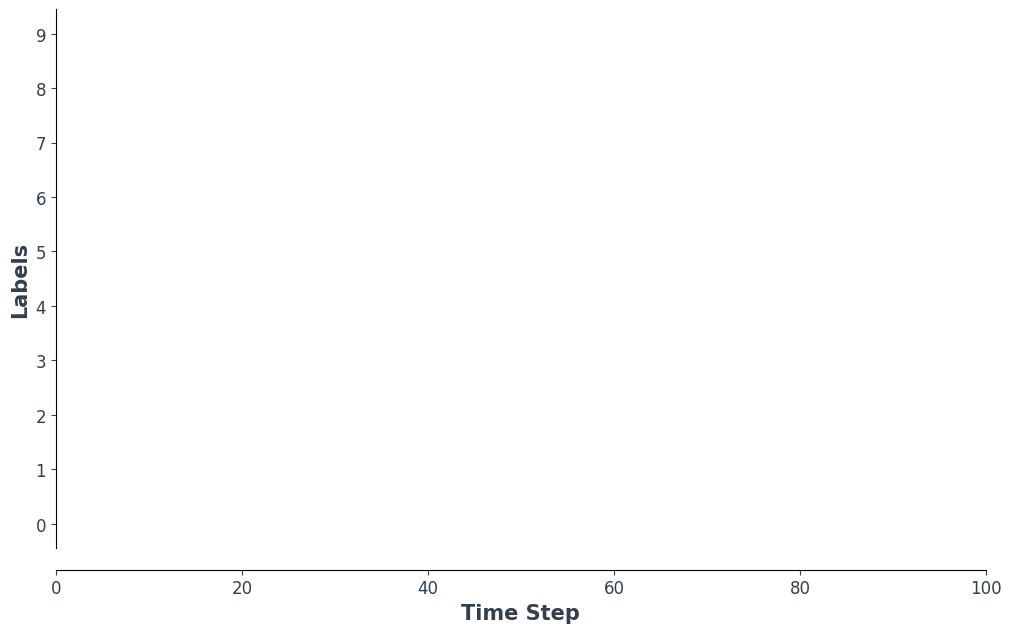

In [17]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()


#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())

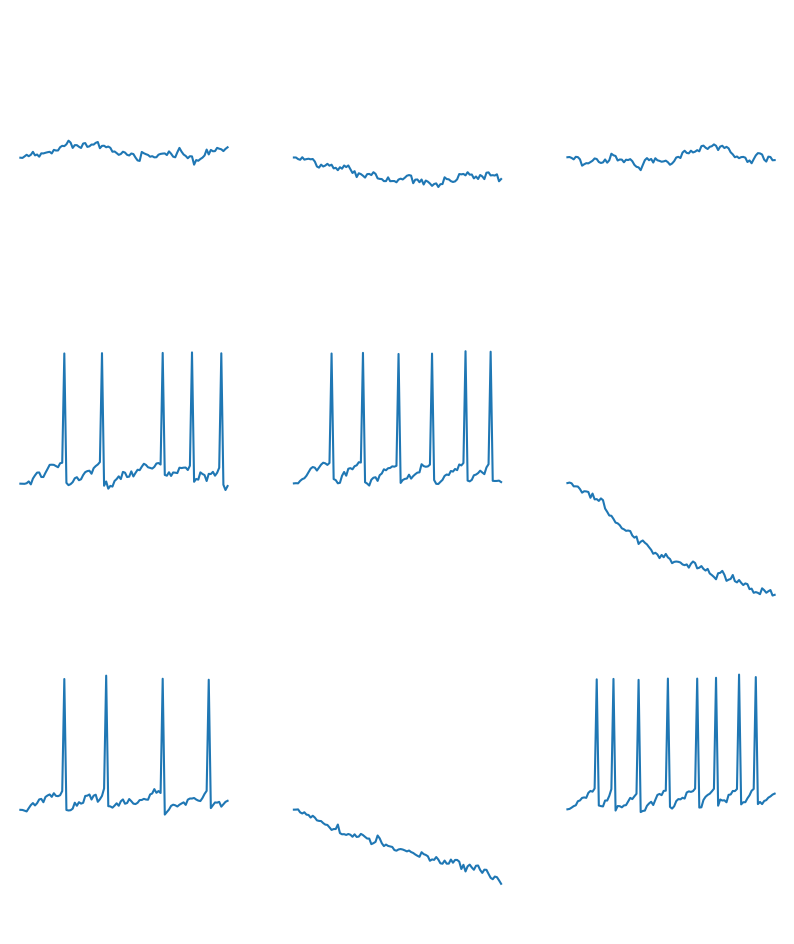

In [18]:
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(10, 12)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': fc1.parameters()}, {'params': fc2.parameters()}], lr=0.01)


In [68]:
correct = 0
total = 0

In [68]:
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784)
        spk_in = spikegen.rate_conv(images).unsqueeze(1)

        optimizer.zero_grad()

        # Forward pass
        cur1 = fc1(spk_in[-1])
        spk1, mem1 = lif1(cur1, mem1)
        cur2 = fc2(spk1)
        spk2, mem2 = lif2(cur2, mem2)

        # Calculate loss
        loss = criterion(spk2[-1], labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print loss for monitoring
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}')

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        spk_in = spikegen.rate_conv(images).unsqueeze(1)

        cur1 = fc1(spk_in[-1])
        spk1, mem1 = lif1(cur1, mem1)
        cur2 = fc2(spk1)
        spk2, mem2 = lif2(cur2, mem2)

        _, predicted = torch.max(spk2[-1].data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test images: {:.2f}%'.format(100 * correct / total)